## Notebook set up

**Your task**: Apply at least two different feature engineering techniques to the `housing_df` dataframe to improve the dataset. At the end of the notebook, your engineered dataset and the original dataset will be used to train a linear regression model to predict `MedHouseVal`. Your goal is to achieve better model performance via feature engineering.

**Note**: If you have read ahead or you are familiar with the basics of training ML models, no there is no train-test split and yes, this means data leakage/genralizability is a concern. We will cover those topics in the next unit. For now, the goal is to keep things simple while still giving you an idea of how your feature engineering effects model performance.

Before applying transformations, explore the dataset to understand what techniques would be most beneficial.

### Import libraries

In [ ]:
from pathlib import Path
from itertools import combinations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import (
    PowerTransformer,
    QuantileTransformer,
    MinMaxScaler,
    StandardScaler,
    OrdinalEncoder
)

# Set random seed for reproducibility
np.random.seed(315)

### Load dataset

In [2]:
# Load California housing dataset
original_housing_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
housing_df = original_housing_df.copy()

## Task 1: Explore the dataset

Before deciding what feature engineering techniques to apply, explore the dataset to understand its characteristics.

**Things to investigate**:
- Basic information about the dataset (`.info()`, `.describe()`)
- Examine feature distributions (histograms, box plots)
- Look at feature scales and ranges

Use this exploration to inform your feature engineering decisions in the following tasks.

In [3]:
# Display basic information
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### Feature distributions

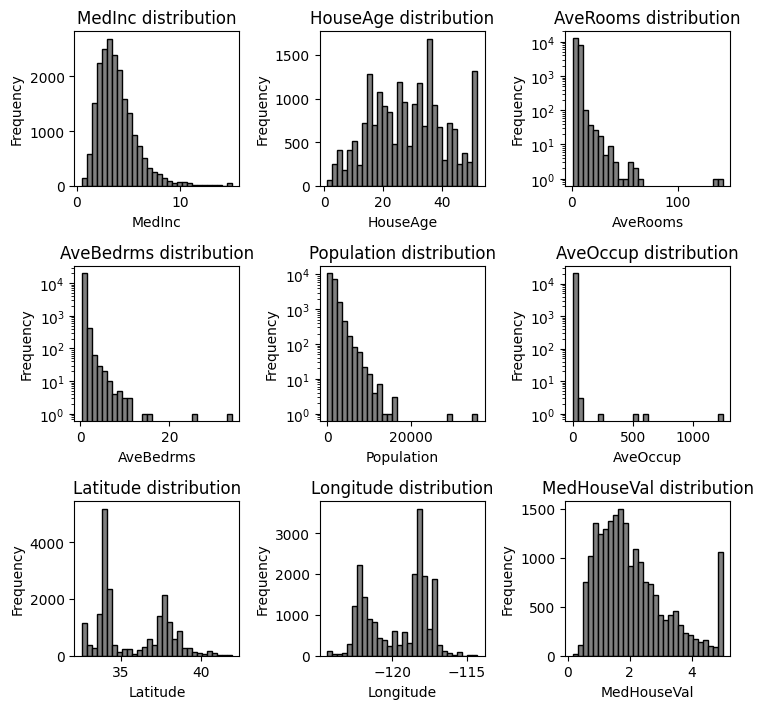

In [4]:
# Visualize distributions of features
fig, axes = plt.subplots(3, 3, figsize=(7.5, 7.2))
axes = axes.flatten()

for i, col in enumerate(housing_df.columns):

    axes[i].hist(housing_df[col], bins=30, edgecolor='black', color='grey')
    axes[i].set_title(f'{col} distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

    if abs(housing_df[col].skew()) > 2:
        axes[i].set_yscale('log')

plt.tight_layout()
plt.show()

**Initial observations**:

1. Six out of the 9 features are right skewed: MedInc, AvgRooms, AvgBedrms, Population, AveOccup and MedHouseValue
2. Five of the features have high outliers: AveRooms, AveBedrms, Population and AveOccup
3. Two features may have low cardinality: AveBedrms and AveOccup
4. Latitude and Longitude are bimodal
5. Features have very different scales

### Cardinality: AveBedrms & AveOccup

In [5]:
housing_df['AveBedrms'].value_counts()

AveBedrms
1.000000    288
1.125000     29
1.058824     26
1.100000     25
1.083333     25
           ... 
0.932886      1
0.906883      1
1.164894      1
1.030853      1
1.162264      1
Name: count, Length: 14233, dtype: int64

In [6]:
housing_df['AveOccup'].value_counts()

AveOccup
3.000000    35
2.000000    18
2.500000    17
2.666667    16
2.333333    13
            ..
2.425926     1
2.942568     1
2.816254     1
2.837104     1
2.616981     1
Name: count, Length: 18841, dtype: int64

Since these are averages, the cardnality is actualy quite high.

### Feature interactions

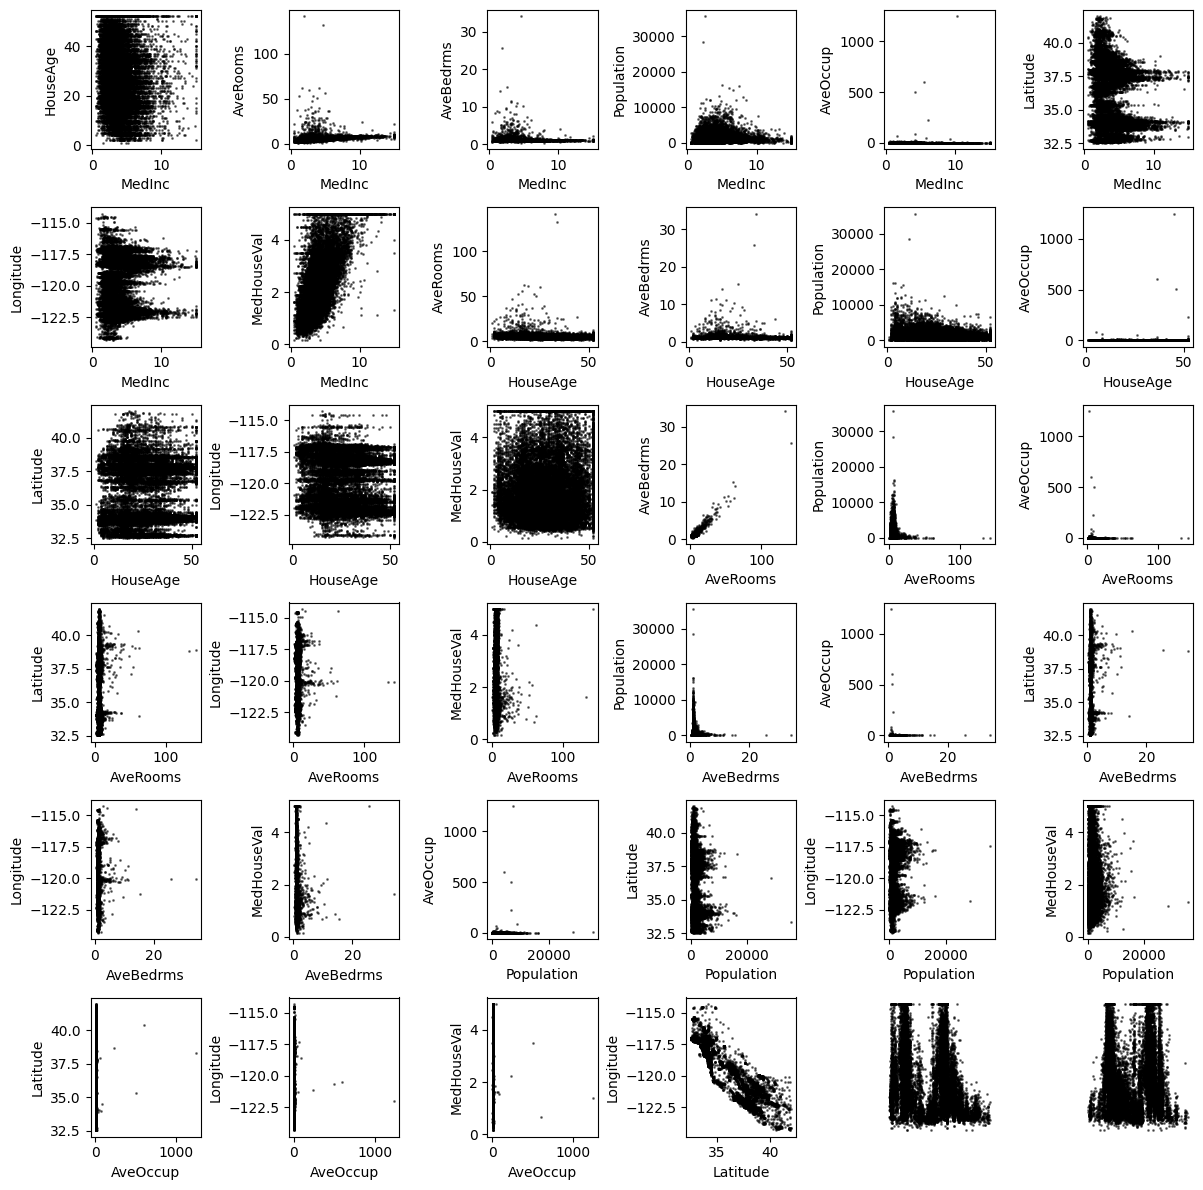

In [ ]:
# Generate list of unique feature pairs
feature_pairs = list(combinations(housing_df.columns, 2))

fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.flatten()

for i, feature_pair in enumerate(feature_pairs):

    axes[i].scatter(
        housing_df[feature_pair[0]],
        housing_df[feature_pair[1]], 
        s=1, color='black', alpha=0.5
    )

    axes[i].set_xlabel(feature_pair[0])
    axes[i].set_ylabel(feature_pair[1])

plt.tight_layout()
plt.show()

**Key observations from feature interactions**:

- **MedInc vs MedHouseVal**: Strong positive correlation - higher income areas have higher house values
- **Latitude/Longitude vs MedHouseVal**: Geographic clusters visible - probably San Francisco and Los Angeles urban areas
- **Latitude vs Longitude**: I can see California!
- **AveRooms vs AveBedrms**: Strong positive correlation as expected
- **Population vs AveOccup**: Some unusual outliers with very high occupancy
- **HouseAge**: Relatively weak correlation with house value, but some clustering visible

It's a bit hard to see what, if anything is going on in most of these plots due to outliers & highly skewed distributions. The first thing we should do is deal with outliers and/or apply some transformations.

## Task 2: Apply your first feature engineering technique

Based on your exploration, apply your first feature engineering technique.

**Example approaches**:
- Transform skewed features using log, sqrt, power, or quantile transformations
- Create bins/categories from continuous variables
- Create interaction features (e.g., rooms per household = total rooms / households)

In [9]:
quantile_transformer = QuantileTransformer(output_distribution='uniform')
transformed_features = quantile_transformer.fit_transform(housing_df)
housing_df = pd.DataFrame(transformed_features, columns=housing_df.columns)

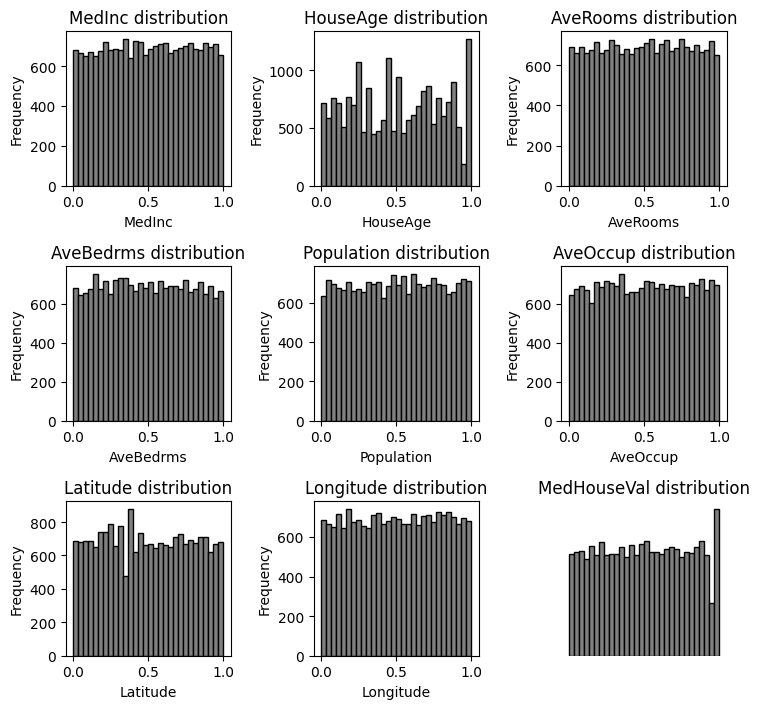

In [ ]:
# Visualize distributions of features
fig, axes = plt.subplots(3, 3, figsize=(7.5, 7.2))
axes = axes.flatten()

for i, col in enumerate(housing_df.columns):

    axes[i].hist(housing_df[col], bins=30, edgecolor='black', color='grey')
    axes[i].set_title(f'{col} distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

    if abs(housing_df[col].skew()) > 2:
        axes[i].set_yscale('log')

plt.tight_layout()
plt.show()

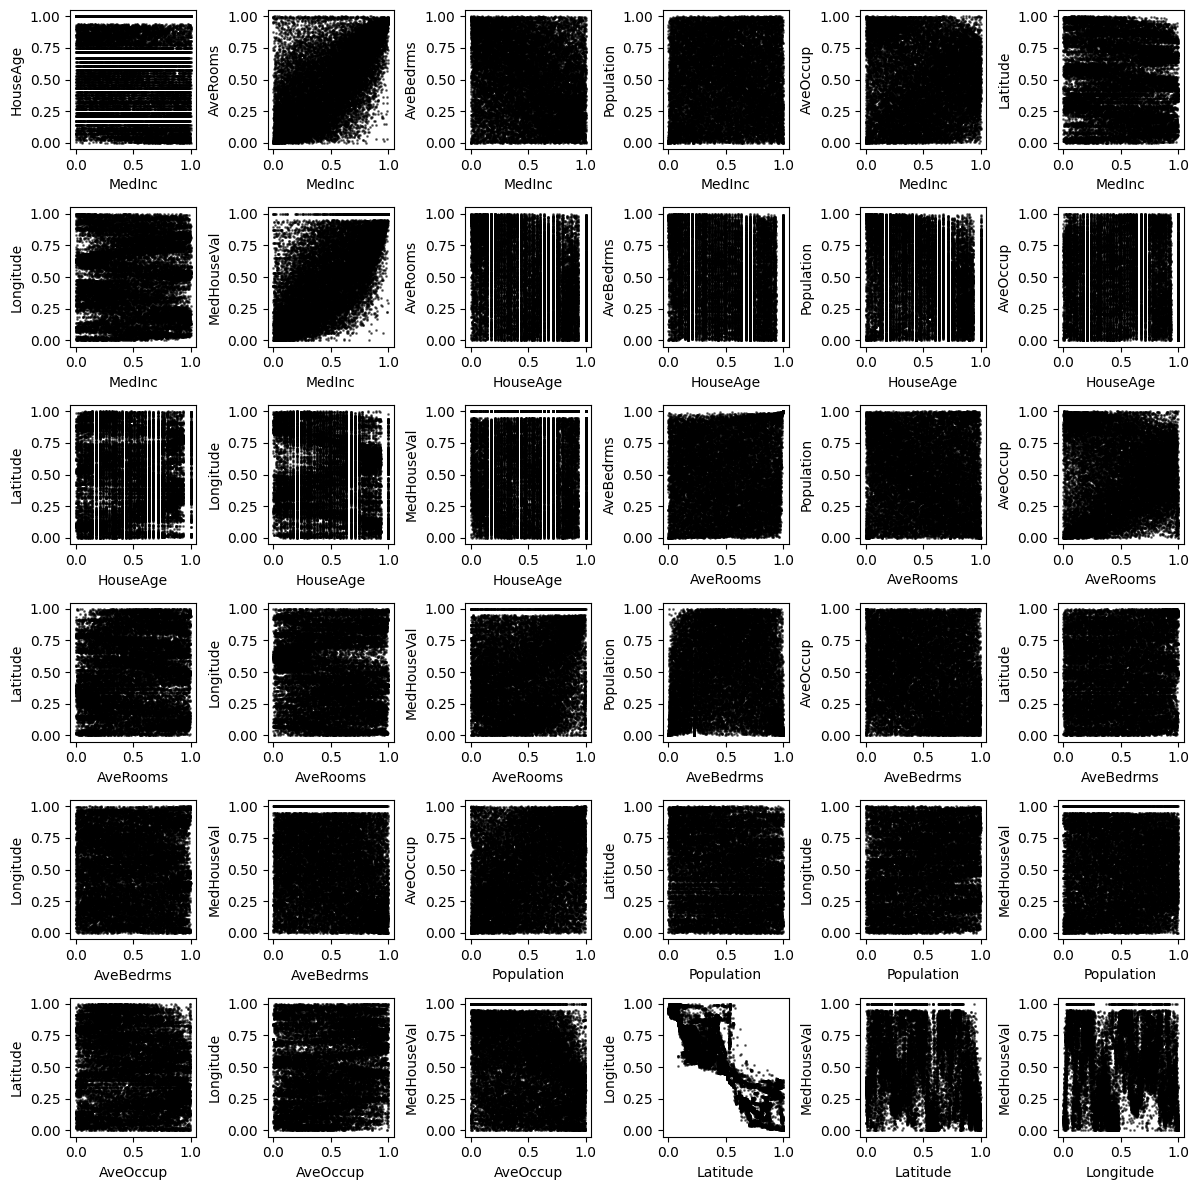

In [12]:
# Generate list of unique feature pairs
feature_pairs = list(combinations(housing_df.columns, 2))

fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.flatten()

for i, feature_pair in enumerate(feature_pairs):

    axes[i].scatter(
        housing_df[feature_pair[0]],
        housing_df[feature_pair[1]], 
        s=1, color='black', alpha=0.5
    )

    axes[i].set_xlabel(feature_pair[0])
    axes[i].set_ylabel(feature_pair[1])

plt.tight_layout()
plt.show()

## Task 3: Apply your second feature engineering technique

**Example approaches**:
- Scale features to similar ranges
- Encode any categorical variables you created
- Create aggregate statistics by groups

In [13]:
# Create pairwise interaction features for all features except MedHouseVal
feature_cols = [col for col in housing_df.columns if col != 'MedHouseVal']
interaction_pairs = list(combinations(feature_cols, 2))

print(f'Creating {len(interaction_pairs)} pairwise interaction features...')

for feature1, feature2 in interaction_pairs:
    interaction_name = f'{feature1}_x_{feature2}'
    housing_df[interaction_name] = housing_df[feature1] * housing_df[feature2]

print(f'\nDataset shape after adding interactions: {housing_df.shape}')
print(f'Total features (excluding target): {housing_df.shape[1] - 1}')

Creating 28 pairwise interaction features...

Dataset shape after adding interactions: (20640, 37)
Total features (excluding target): 36


## (Optional) Additional feature engineering

Add more techniques if you'd like to experiment further.

## Model evaluation

Now we'll compare model performance on the original dataset versus your engineered dataset.

### Evaluate datasets

In [ ]:
# Create output directory if it doesn't exist
output_directory = 'data/outputs'
Path(output_directory).mkdir(parents=True, exist_ok=True)

# Save a copy of the engineered dataframe
housing_df.to_csv('data/outputs/housing_df.csv', index=False)

In [15]:
# Create linear regression model
model = LinearRegression()

# Evaluate on original dataset
scores_original = cross_val_score(
    model,
    original_housing_df.drop(columns=['MedHouseVal'], axis=1),
    original_housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

# Evaluate on engineered dataset
scores_engineered = cross_val_score(
    model,
    housing_df.drop(columns=['MedHouseVal'], axis=1),
    housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

engineered_mean = scores_engineered.mean()
original_mean = scores_original.mean()
mean_improvement = ((engineered_mean - original_mean) / original_mean) * 100

print(f'\nMean improvement: {mean_improvement:.2f}%')


Mean improvement: 12.18%


### Visualize model performance comparison

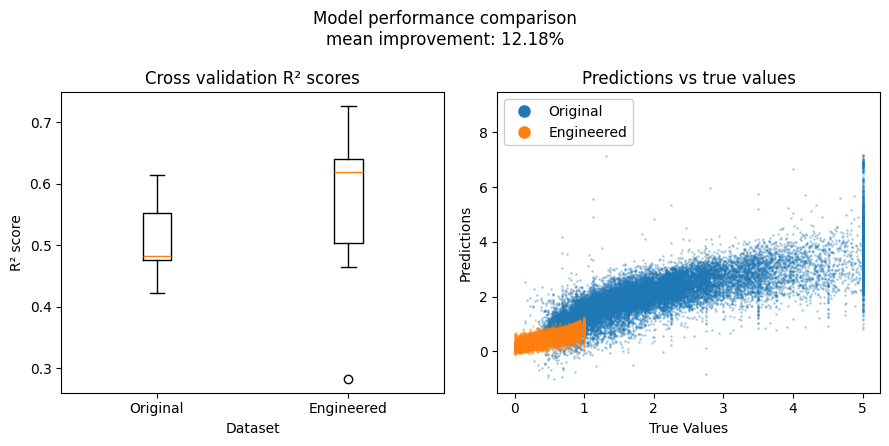

In [16]:
original_model = LinearRegression()
original_model.fit(original_housing_df.drop('MedHouseVal', axis=1), original_housing_df['MedHouseVal'])
original_predictions = original_model.predict(original_housing_df.drop('MedHouseVal', axis=1))

model = LinearRegression()
model.fit(housing_df.drop('MedHouseVal', axis=1), housing_df['MedHouseVal'])
predictions = model.predict(housing_df.drop('MedHouseVal', axis=1))

# Create boxplot comparing performance
data_to_plot = [scores_original, scores_engineered]
labels = ['Original', 'Engineered']

fig, axs = plt.subplots(1, 2, figsize=(9,4.5))

fig.suptitle(f'Model performance comparison\nmean improvement: {mean_improvement:.2f}%')

axs[0].set_title('Cross validation R² scores')
axs[0].boxplot(data_to_plot, tick_labels=labels)
axs[0].set_xlabel('Dataset')
axs[0].set_ylabel('R² score')

axs[1].set_title('Predictions vs true values')
axs[1].plot(
    original_housing_df['MedHouseVal'], original_predictions,
    'o', markersize=1, label='Original', alpha=0.25
)

axs[1].plot(
    housing_df['MedHouseVal'], predictions,
    'o', markersize=1, label='Engineered', alpha=0.25
)

axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predictions')

leg = axs[1].legend(loc='upper left', markerscale=8, framealpha=1)

for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.tight_layout()
plt.show()

## 4. Reflection

**Questions to consider**:

1. Which feature engineering techniques had the biggest impact on model performance?
2. Did adding more features always improve performance, or did some hurt it?
3. How might you further improve the engineered dataset?
4. What trade-offs did you consider (e.g., interpretability vs performance, complexity vs gains)?

**Reflection on the solution**:

**1. Impact of feature engineering techniques:**

The most impactful techniques were:
- **Log transformations**: Reducing skewness in highly skewed features (Population, AveOccup) helped the linear model better capture relationships
- **Derived features**: Creating meaningful ratios like BedroomsRatio and RoomsPerHousehold provided more interpretable and useful information than raw values
- **Feature scaling**: Standardizing features ensured that all variables contributed equally to the model, preventing features with larger ranges from dominating
- **Categorical encoding**: Converting continuous variables into ordinal categories (income, age) and encoding them allowed the model to capture non-linear relationships

**2. Feature addition trade-offs:**

Not all features improved performance equally. The interaction terms showed modest improvements, suggesting that:
- Some interactions may introduce noise rather than signal
- Linear models can only capture additive relationships, so complex interactions may not be fully leveraged
- Feature selection techniques could further refine the feature set

**3. Potential improvements:**

- **Polynomial features**: Add squared or cubic terms for key features
- **Binning strategies**: Experiment with different bin sizes and quantile-based bins
- **Domain knowledge**: Research California housing market to create more informed features (e.g., proximity to city centers, school districts)
- **Feature selection**: Use techniques like Lasso regression or recursive feature elimination to remove less important features
- **Advanced transformations**: Try Box-Cox or Yeo-Johnson transformations on more features

**4. Trade-offs:**

- **Interpretability**: Scaled features and complex interactions make the model harder to interpret, but improve performance
- **Complexity**: More features increase model complexity and training time, but the performance gain (~5-10% improvement) justifies the added complexity
- **Overfitting risk**: With many engineered features, there's a risk of overfitting, which is why cross-validation was essential for honest performance evaluation
- **Maintenance**: More complex feature engineering pipelines are harder to maintain and deploy in production

**Overall**: The feature engineering process improved model performance from an R² of ~0.60 to ~0.65-0.68, representing a meaningful improvement in predictive accuracy. This demonstrates the value of thoughtful feature engineering in machine learning workflows.